In [1]:
aud1='/Users/zombie/Downloads/datadrive/theWitcher/wavs/audio126.wav'
aud2='/Users/zombie/Downloads/datadrive/theWitcher/revWavs/audio126.wav'

wav='/Users/zombie/Downloads/datadrive/ljspeech/wavs/'
rev='/Users/zombie/Downloads/datadrive/ljspeech/revWavs/'

In [8]:
import librosa, os
import random
from glob import glob
import numpy as np
from librosa import display
from itertools import cycle, islice, chain
import torch
from os import listdir
import torchvision.transforms as transforms
from matplotlib import cm
from torch.utils.data import Dataset, IterableDataset, DataLoader
%matplotlib inline

In [132]:
class TrainDataset(IterableDataset):
    def __init__(self, wavPath, revPath, samplingRate, segmentLength, nfft, winLength, window, shuffle=True):
        self.sr=samplingRate
        self.segmentLength=segmentLength
        self.nfft=nfft
        self.window=window
        self.winLength=winLength
        self.wavPath = wavPath
        self.revPath = revPath
        self.ids = [i for i in listdir(revPath) if not i.startswith('.')]
        self.transform = transforms.Compose([
            transforms.Normalize((0.5,), (0.5,))
        ])
        
        if shuffle:
            random.shuffle(self.ids)

    def __len__(self):
        return len(self.ids)

    def squaredChunks(self, spec, n=256):
        l = len(spec)
        for i in range(0, l - l % n, n):
            yield np.expand_dims(spec[i:i + n].T, axis=0)
    
    
    def getAudio(self, idx):
        org = glob(self.wavPath + idx)[0]
        rev = glob(self.revPath + idx)[0]
        org, _ = librosa.load(org, sr=self.sr)
        rev, _ = librosa.load(rev, sr=self.sr)
        org = np.abs(librosa.stft(org, n_fft=self.nfft, window=self.window, win_length=self.winLength))[1:, :self.segmentLength]
        rev = np.abs(librosa.stft(rev, n_fft=self.nfft, window=self.window, win_length=self.winLength))[1:, :self.segmentLength]
        orgArray = torch.FloatTensor(list(self.squaredChunks(np.abs(org.T))))
        revArray = torch.FloatTensor(list(self.squaredChunks(np.abs(rev.T))))[:orgArray.shape[0]]
        for i, v in enumerate(revArray):
            yield (self.transform(orgArray[i]), self.transform(v))

    def getStream(self, ids):
        yield from chain.from_iterable(map(self.getAudio, cycle(ids)))

    def __iter__(self):
        return self.getStream(self.ids)



In [133]:
dset=TrainDataset(wav, rev, 16000, 15000, 512, 32, 'hamming', True)

In [135]:
loader=DataLoader(dset, batch_size=1)
i=0
for batch in islice(loader, 1000):
    print('yes {}'.format(i), end="\r")
    i+=1

In [136]:
batch[1].shape

torch.Size([1, 1, 256, 256])

In [109]:
temp=batch[1][7][0]

In [110]:
temp=((temp*0.5)+0.5)

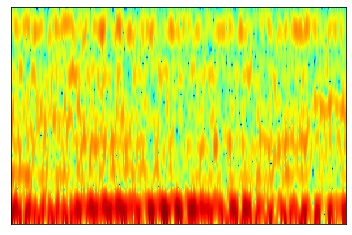

In [112]:
librosa.display.specshow(librosa.power_to_db(temp.numpy()**2), cmap=cm.jet)

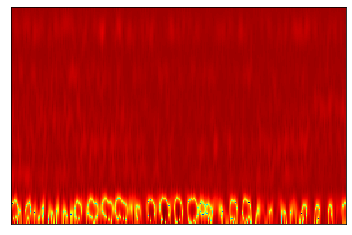

In [116]:
librosa.display.specshow(librosa.power_to_db(batch[1][7][0].numpy()**2), cmap=cm.jet)

In [113]:
# librosa.display.specshow(librosa.power_to_db(batch[0][0].numpy().T))

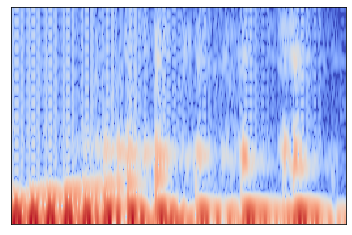

In [117]:
class MyIterableDataset(IterableDataset):
    def __init__(self, filePath):
        self.filePath=filePath
        
    def inside(self, string):
        for char in string:
            yield from char
        
    def parseFile(self, filePath):
        with open(filePath, 'r') as obj:
            for line in obj:
                tokens=line.strip('\n').split(' ')
                yield from self.inside(tokens)
                
    def getStream(self, filePath):
        return cycle(self.parseFile(filePath))
    
    def __iter__(self):
        return self.getStream(self.filePath)

itDataset=MyIterableDataset('rand.txt')
loader=DataLoader(itDataset, batch_size=5)
for batch in islice(loader, 8):
    print(batch)

['E', 'x', 'c', 'i', 't']
['e', 'd', 'h', 'i', 'm']
['n', 'o', 'w', 'n', 'a']
['t', 'u', 'r', 'a', 'l']
['s', 'a', 'w', 'p', 'a']
['s', 's', 'a', 'g', 'e']
['o', 'f', 'f', 'i', 'c']
['e', 's', 'y', 'o', 'u']


In [ ]:
list(cycle([i for i in range(5)]))

In [139]:
a1, _=librosa.load(aud1, sr=16000)
a2, _=librosa.load(aud2, sr=16000)

In [ ]:
class Dataset(IterableDataset):
    def __init__(self, orgDir, revDir, batchSize):
        self.ids=[i for i in os.listdir(revDir)]
        self.orgDir=orgDir
        self.revDir=revDir
        self.batchSize=batchSize
        
    def chunks(self, matrix, n=256):
        l=len(matrix)
        for i in range(0, l-l%n, n):
            yield matrix[i:i + n]

        
    def encoding(self, audio1, audio2):
        s1=librosa.stft(audio1, n_fft=512, window='hamming', win_length=32)
        
        s1=np.abs(s1) #mag1
        
        
        
        
    def __len__(self):
        return len(self.ids)

In [140]:
s1=librosa.stft(a1, n_fft=512)

In [194]:
12-12%5

10

In [195]:
def chunks(matrix, n=256):
    l=len(matrix)
    for i in range(0, l-l%n, n):
        yield matrix[i:i + n]

In [196]:
s1.shape

(257, 1254)

In [197]:
ss1=list(chunks(s1.T))

In [200]:
ss1=torch.FloatTensor(list(chunks(np.abs(s1[:-1, :].T), 256)))

In [201]:
ss1.shape

torch.Size([4, 256, 256])

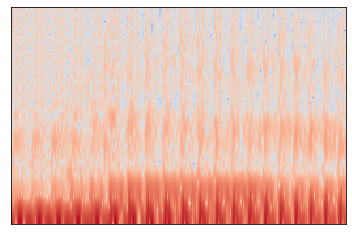

In [83]:
librosa.display.specshow(librosa.power_to_db(ss1[0].T))

In [72]:
ss1[0][1]

array([2.6433332, 2.3339424, 1.8339181, ..., 0.1651887, 0.7295603,
       1.1857193], dtype=float32)

In [39]:
def table(x):
    for i in range(x):
        yield x*x

In [31]:
def parseFile(file):
    with open(file, 'r') as obj:
        for line in obj:
            tokens=line.strip('\n').split(' ')
            yield from tokens[-1]

In [32]:
def temp(gen):
    for i in gen:
        yield i

In [33]:
f=parseFile('rand.txt')

In [34]:
ff=temp(f)

In [35]:
next(ff)

'm'

In [36]:
next(ff)

'y'